<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Выгрузка требуемых библиотек.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

Выгрузим датасет и выполним ресемплирование по одному часу..

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
if ~data.index.is_monotonic:
    data.sort_index(inplace=True)

In [3]:
data = data.resample('1H').sum()

In [4]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Изучим данные.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
data.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Данные не требуют предобработки: в них отсутсвуют пропуски, дубликаты, аномалии и выбросы.

Вывод:

Были выгружены данные о заказах такси в аэропортах за период с 2018-03-01 до 2018-08-31. Данные не требуют предобработки: в них отсутсвуют пропуски, дубликаты, аномалии и выбросы. Также было проведено ресемплирование этих данных по одному часу. 

## Анализ

Создадим следующие признаки: календарные (час, день недели, день, месяц), отстающие значения и скользящее среднее.

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

data_with_features = make_features(data, 20, 100)

Построим график скользящего среднего количества заказов в зависимости от времени.

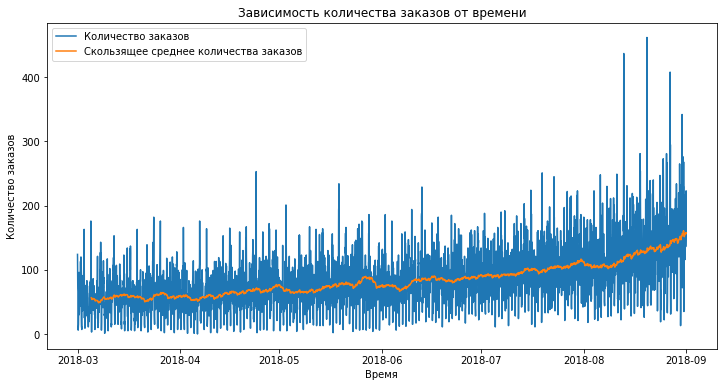

In [8]:
plt.figure(figsize=(12,6))
plt.plot(data_with_features['num_orders']);
plt.plot(data_with_features['rolling_mean']);
plt.title('Зависимость количества заказов от времени')
plt.xlabel('Время');
plt.ylabel('Количество заказов');
plt.legend(['Количество заказов', 'Скользящее среднее количества заказов']);

На графике скользящего среднего количества заказов наблюдается рост количества заказов (пик достигается в конце августа).
Так как сглаженное среднее увеличивается со временем, то ряд может быть нестационарен. Дополнительно проведем тест Дики–Фуллера.

Тест ADF (расширенный тест Дики–Фуллера) – проверка статистической значимости, которая демонстрирует результаты проверки нулевой гипотезы альтернативной. В результате мы получим P-значение, из которого можно сделать вывод о стационарности временного ряда.

Когда мы создаем прогнозирующую модель для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой ковариацией выборок одного размера. Ковариация – мера взаимосвязи двух случайных величин, измеряющая общее отклонение двух случайных величин от их ожидаемых значений. Метрика оценивает, в какой степени переменные изменяются вместе. Другими словами, это мера дисперсии между двумя переменными.

Нулевая гипотеза: предполагает, что временной ряд нестационарный.

Альтернативная гипотеза: предполагает, что временной ряд является стационарным. 

P-values — это наименьшее значение уровня значимости (то есть вероятности отказа от справедливой гипотезы).

In [9]:
result = adfuller(data_with_features['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] > result[4]["5%"]:
    print ("Временной ряд не стационарен")
else:
    print ("Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Временной ряд стационарен


В результате мы видим, что P-значение, полученное в результате теста, меньше уровня значимости равному 0,05, а значит временной ряд стационарен.

Построим гистограммы среднего количества заказов в зависимости от времени.

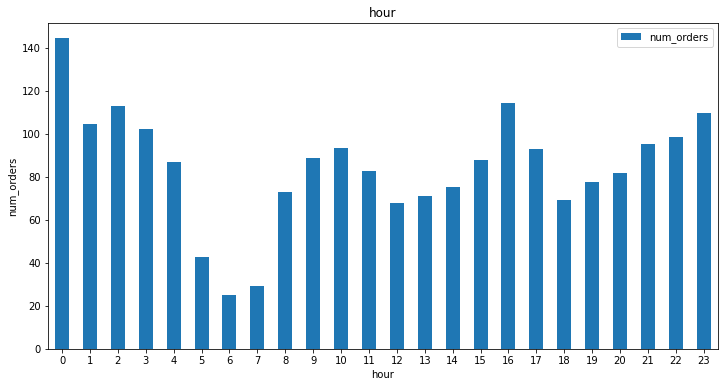

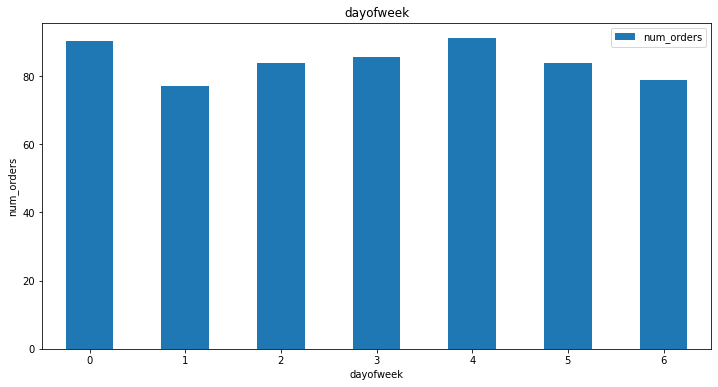

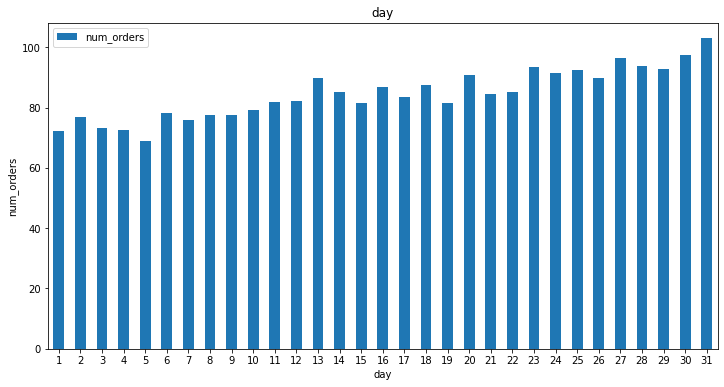

In [10]:
for c in ['hour', 'dayofweek', 'day']:
    pd.pivot_table(data_with_features, 
                   values='num_orders', 
                   index=c, 
                   aggfunc='mean') \
      .plot(kind='bar',
            title=c,
            xlabel=c,
            ylabel='num_orders',
            rot=0,
            figsize=(12,6))

- Самое популярное время для заказа такси - полночь
- Чаще всего такси заказывают в понедельник и пятницу
- К концу рассматриваемого промежутка времени (к лету) количество заказов было максимальным

Построим графики тренда, сезонности и остатка для всего рассматриваемого промежутка времени.

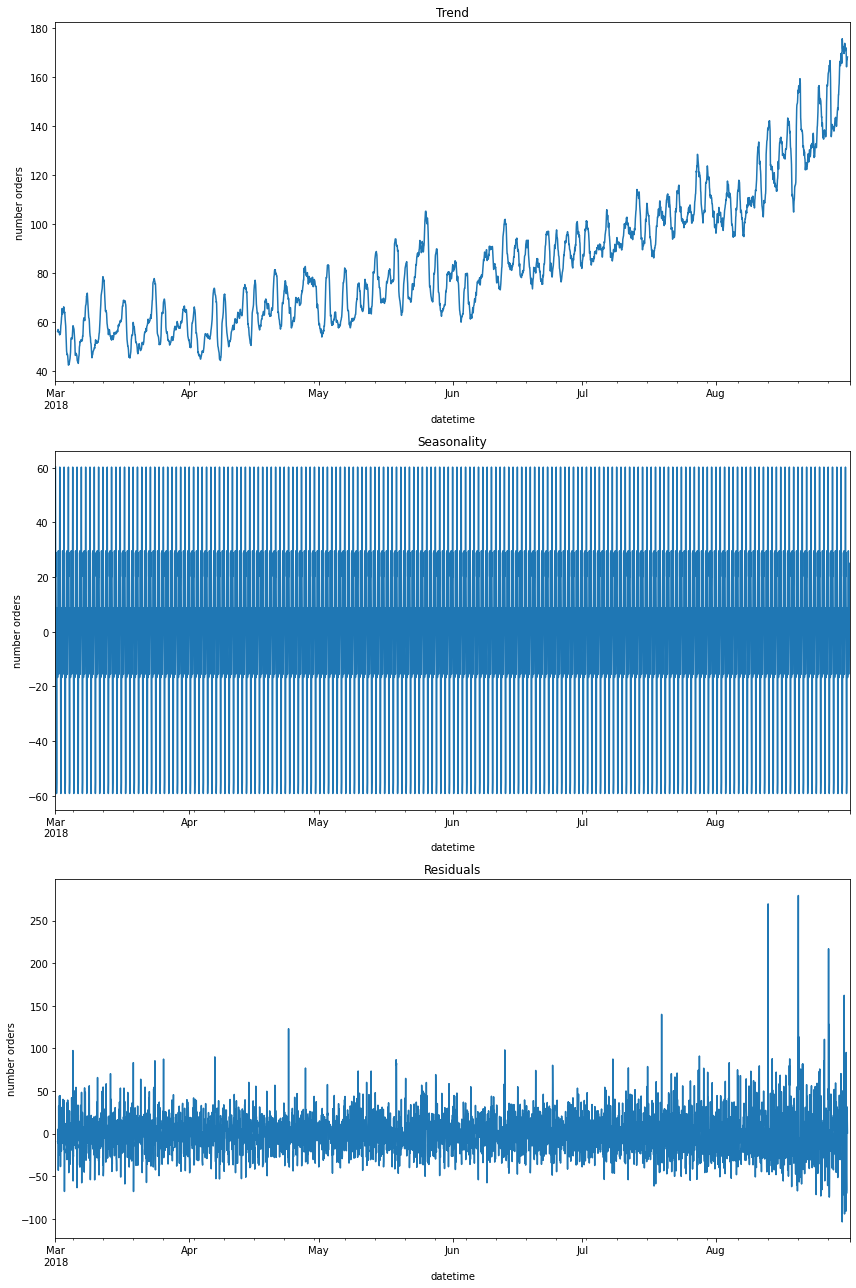

In [11]:
decomposed = seasonal_decompose(data_with_features['num_orders']) 
plt.figure(figsize=(12,18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('number orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('number orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('number orders')
plt.tight_layout()

Наблюдается тренд увеличения количества заказов, циклично повторяющиеся закономерности на графике сезонности надо изучить подробнее. 

Построим график сезонности для первой недели августа.

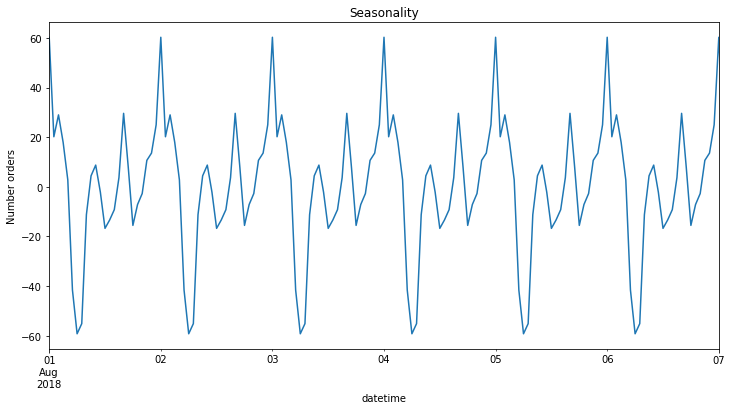

In [12]:
plt.figure(figsize=(12,6));
decomposed.seasonal.plot();
plt.xlim(('2018-08-01', '2018-08-07'));
plt.title('Seasonality');
plt.ylabel('Number orders');

Циклично повторяющиеся закономерности на графике сезонности присутствуют (в зависимости от времени суток). Изучим их подробнее.

Построим график сезонности для первого дня августа.

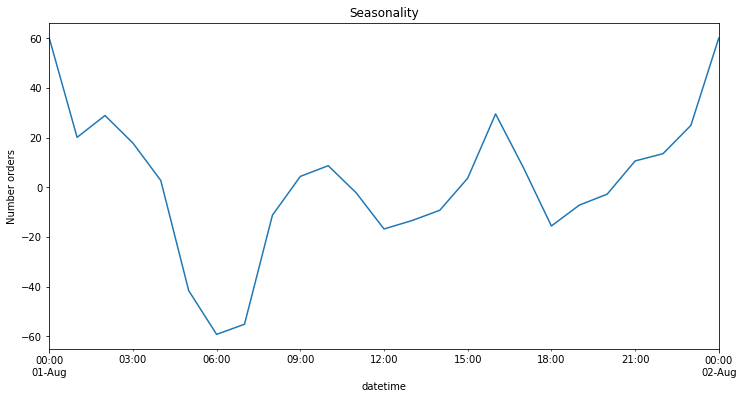

In [13]:
plt.figure(figsize=(12,6));
decomposed.seasonal.plot();
plt.xlim(('2018-08-01', '2018-08-02'));
plt.title('Seasonality');
plt.ylabel('Number orders');

Меньше всего заказов такси происходит в 6.00, больше всего в полночь. Это может быть связано с тем, что чаще всего перелеты осуществляются в ночь, а перелеты в утреннее время менее популярны.

Вывод:

- На графике скользящего среднего количества заказов наблюдается рост количества заказов (пик достигается в конце августа).
- Дополнительно был проведен тест Дики–Фуллера, где было доказано, что временной ряд является стационнарным.
- Самое популярное время для заказа такси - полночь.
- Чаще всего такси заказывают в понедельник и пятницу.
- Наблюдается тренд увеличения количества заказов, циклично повторяющиеся закономерности на графике сезонности присутствуют (в зависимости от времени суток). Меньше всего заказов такси происходит в 6.00, больше всего в полночь. Это может быть связано с тем, что чаще всего перелеты осуществляются в ночь, а перелеты в утреннее время менее популярны.

## Обучение

Разделим датасет на обучающую и тестовую выборку.

In [14]:
train, test = train_test_split(data_with_features,
                               shuffle=False, 
                               test_size=0.1, 
                               random_state=13)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

Используем TimeSeriesSplit для кросс-валидации временных рядов.

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

Обучим модель LinearRegression() и проведем кросс-валидацию.

In [16]:
%%time
lr = LinearRegression()
scores = cross_val_score(estimator=lr, 
                         X=features_train, 
                         y=target_train, 
                         cv=tscv,
                         scoring='neg_root_mean_squared_error', 
                         verbose=0)
print(abs(np.mean(scores)))

30.700289820338394
CPU times: user 184 ms, sys: 212 ms, total: 396 ms
Wall time: 331 ms


Модель LinearRegression() при кросс-валидации имеет метрику RMSE равную 30.700.

Обучим модель RandomForestRegressor() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров max_depth и n_estimators.

In [17]:
%%time
model = RandomForestRegressor(random_state=13)
params = {
    'n_estimators': [20,60,100],
    'max_depth': [None] + [i for i in range(2,10,2)],
    }
grid_imba_rfr = GridSearchCV(model, 
                             param_grid=params,
                             verbose=1,
                             cv=tscv, 
                             scoring='neg_root_mean_squared_error', 
                             n_jobs=-1)
grid_imba_rfr.fit(features_train, target_train)
print(grid_imba_rfr.best_params_)
print(abs(grid_imba_rfr.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'max_depth': None, 'n_estimators': 100}
25.043253009682005
CPU times: user 58.2 s, sys: 195 ms, total: 58.4 s
Wall time: 1min


Модель RandomForestRegressor() при параметре n_estimators равному 100 и параметре max_depth равному None имеет наилучшую метрику RMSE, которая равняется 25,043.

Обучим модель CatBoostRegressor() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров n_estimators, depth и learning_rate.

In [18]:
%%time
model = CatBoostRegressor(random_state=13)
params = {'depth'         : [2,4,6],
          'learning_rate' : [0.01,0.05,0.1],
          'n_estimators'    : [500,1000]
         }
grid_imba_cbr = GridSearchCV(model, 
                             param_grid=params,
                             cv=tscv, 
                             scoring='neg_root_mean_squared_error',
                             verbose=2,
                             n_jobs=-1)
grid_imba_cbr.fit(features_train, target_train)
print(grid_imba_cbr.best_params_)
print(abs(grid_imba_cbr.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 29.0654302	total: 47ms	remaining: 23.4s
1:	learn: 28.9979782	total: 47.6ms	remaining: 11.9s
2:	learn: 28.8919308	total: 48.1ms	remaining: 7.97s
3:	learn: 28.8050033	total: 48.6ms	remaining: 6.03s
4:	learn: 28.6997693	total: 49.1ms	remaining: 4.86s
5:	learn: 28.5950883	total: 49.6ms	remaining: 4.08s
6:	learn: 28.4833081	total: 50.2ms	remaining: 3.53s
7:	learn: 28.4014650	total: 50.6ms	remaining: 3.11s
8:	learn: 28.3276727	total: 51.1ms	remaining: 2.79s
9:	learn: 28.2503991	total: 51.6ms	remaining: 2.53s
10:	learn: 28.1722755	total: 52.1ms	remaining: 2.32s
11:	learn: 28.0669686	total: 52.6ms	remaining: 2.14s
12:	learn: 27.9808931	total: 53.1ms	remaining: 1.99s
13:	learn: 27.9078084	total: 53.6ms	remaining: 1.86s
14:	learn: 27.8451513	total: 54.1ms	remaining: 1.75s
15:	learn: 27.7875696	total: 54.6ms	remaining: 1.65s
16:	learn: 27.7018415	total: 55.3ms	remaining: 1.57s
17:	learn: 27.6338664	total: 55.8ms	remaining: 1.4

Модель CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05 имеет наилучшую метрику RMSE, которая равняется 24,862.

Вывод:

Были обучены модели LinearRegression(), RandomForestRegressor) и CatBoostRegressor() при использования поиска по сетке при помощи GridSearchCV().

- Модель LinearRegression() при кросс-валидации имеет метрику RMSE равную 30.700.
- Модель RandomForestRegressor() при параметре n_estimators равному 100 и параметре max_depth равному None имеет наилучшую метрику RMSE, которая равняется 25,043.
- Модель CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05 имеет наилучшую метрику RMSE, которая равняется 24,862.

Наилучшей является модель CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05, данная модель имеет метрику RMSE, которая равняется 24,862.

## Тестирование

Получим метрику на константной модели, чтобы проверить полученную выше модель на адекватность.

In [19]:
dummy = DummyRegressor(strategy='mean').fit(features_train, target_train) 
predictions_dummy = dummy.predict(features_test) 
rmse = mean_squared_error(target_test, predictions_dummy)**0.5
rmse

84.33764728516337

Предскажем значения на наилучшей модели - CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05.

In [20]:
predictions = grid_imba_cbr.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
rmse

44.58354652998731

RMSE на тестовой выборке равняется 44.584, что является допустимым по условию заказчика (меньше 48) и адекватным по сравнению с константной омделью (меньше 84).

Постром график факт-прогноз.

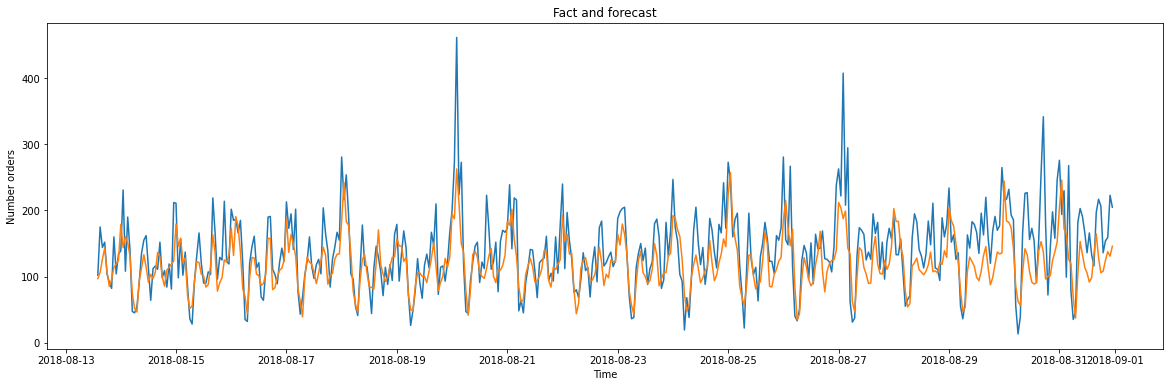

In [21]:
plt.figure(figsize=(20,6))
sns.lineplot(data=target_test);
sns.lineplot(x=target_test.index, y=predictions);
plt.title('Fact and forecast')
plt.xlabel('Time');
plt.ylabel('Number orders');

Модель сильнее всего ошибается при пиках и спадах значений количества заказов.

Вывод:

- RMSE на тестовой выборке для лучшей модели равняется 44.584, что является допустимым по условию заказчика (меньше 48) и адекватным по сравнению с константной моделью (меньше 84).
- Был построен график факт-прогноз. Модель сильнее всего ошибается при пиках и спадах значений количества заказов.

# Вывод 

**Описание**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо было спрогнозировать количество заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Подготовка**

Были выгружены данные о заказах такси в аэропортах за период с 2018-03-01 до 2018-08-31. Данные не требуют предобработки: в них отсутсвуют пропуски, дубликаты, аномалии и выбросы. Также было проведено ресемплирование этих данных по одному часу.

**Анализ**

- На графике скользящего среднего количества заказов наблюдается рост количества заказов (пик достигается в конце августа).
- Дополнительно был проведен тест Дики–Фуллера, где было доказано, что временной ряд является стационнарным.
- Самое популярное время для заказа такси - полночь.
- Чаще всего такси заказывают в понедельник и пятницу.
- Наблюдается тренд увеличения количества заказов, циклично повторяющиеся закономерности на графике сезонности присутствуют (в зависимости от времени суток). Меньше всего заказов такси происходит в 6.00, больше всего в полночь. Это может быть связано с тем, что чаще всего перелеты осуществляются в ночь, а перелеты в утреннее время менее популярны.

**Обучение**

Были обучены модели LinearRegression(), RandomForestRegressor) и CatBoostRegressor() при использования поиска по сетке при помощи GridSearchCV().

- Модель LinearRegression() при кросс-валидации имеет метрику RMSE равную 30.700.
- Модель RandomForestRegressor() при параметре n_estimators равному 100 и параметре max_depth равному None имеет наилучшую метрику RMSE, которая равняется 25,043.
- Модель CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05 имеет наилучшую метрику RMSE, которая равняется 24,862.

Наилучшей является модель CatBoostRegressor() при параметре n_estimators равному 500, параметре depth равному 6 и параметре learning_rate равному 0,05, данная модель имеет метрику RMSE, которая равняется 24,862.

**Тестирование** 

- RMSE на тестовой выборке для лучшей модели равняется 44.584, что является допустимым по условию заказчика (меньше 48) и адекватным по сравнению с константной омделью (меньше 84).
- Был построен график факт-прогноз. Модель сильнее всего ошибается при пиках и спадах значений количества заказов.